# Introduction

This project set out to decide the best neighborhood in Pittsburgh by combining three metrics: how many acres of park a neighborhood had, how many public art installations it had, and how good its parking was (in terms of parking cost and availability). We generally felt confident in our metrics, and decided on them fairly quickly. Each of our metrics represents an important aspect of life in any neighborhood: healthy access to nature, being able to see human creativity, and, of course, an appropriate transportation situation. Some variation in how to go about representing the best among these metrics was deliberated, though. For example, we considered implementing a graph algorithm to determine *distance* to parks instead of acres of parks within a neighborhood, but eventually scrapped that idea. Also, we had to come up with a way to normalize all of our numerical data in a way that could give us a consolidated series of data that we could analyze for the single best (discussed in the section below). Finally, though, we did determine what we set out to solve: the best neighborhoods in Pittsburgh.

# The Individual Metrics / Analyses

Before combining our metrics to pick the single best neighborhood, we needed to perform our own basic analyses and manipulate our individual datasets. The three individual metrics were:

1. Acres of park (more acres -> better neighborhood)
2. Number of public art installations (more art -> better neighborhood)
3. Rates and availability of metered parking (lower rates, more availability -> better neighborhood)

## Acres of Park

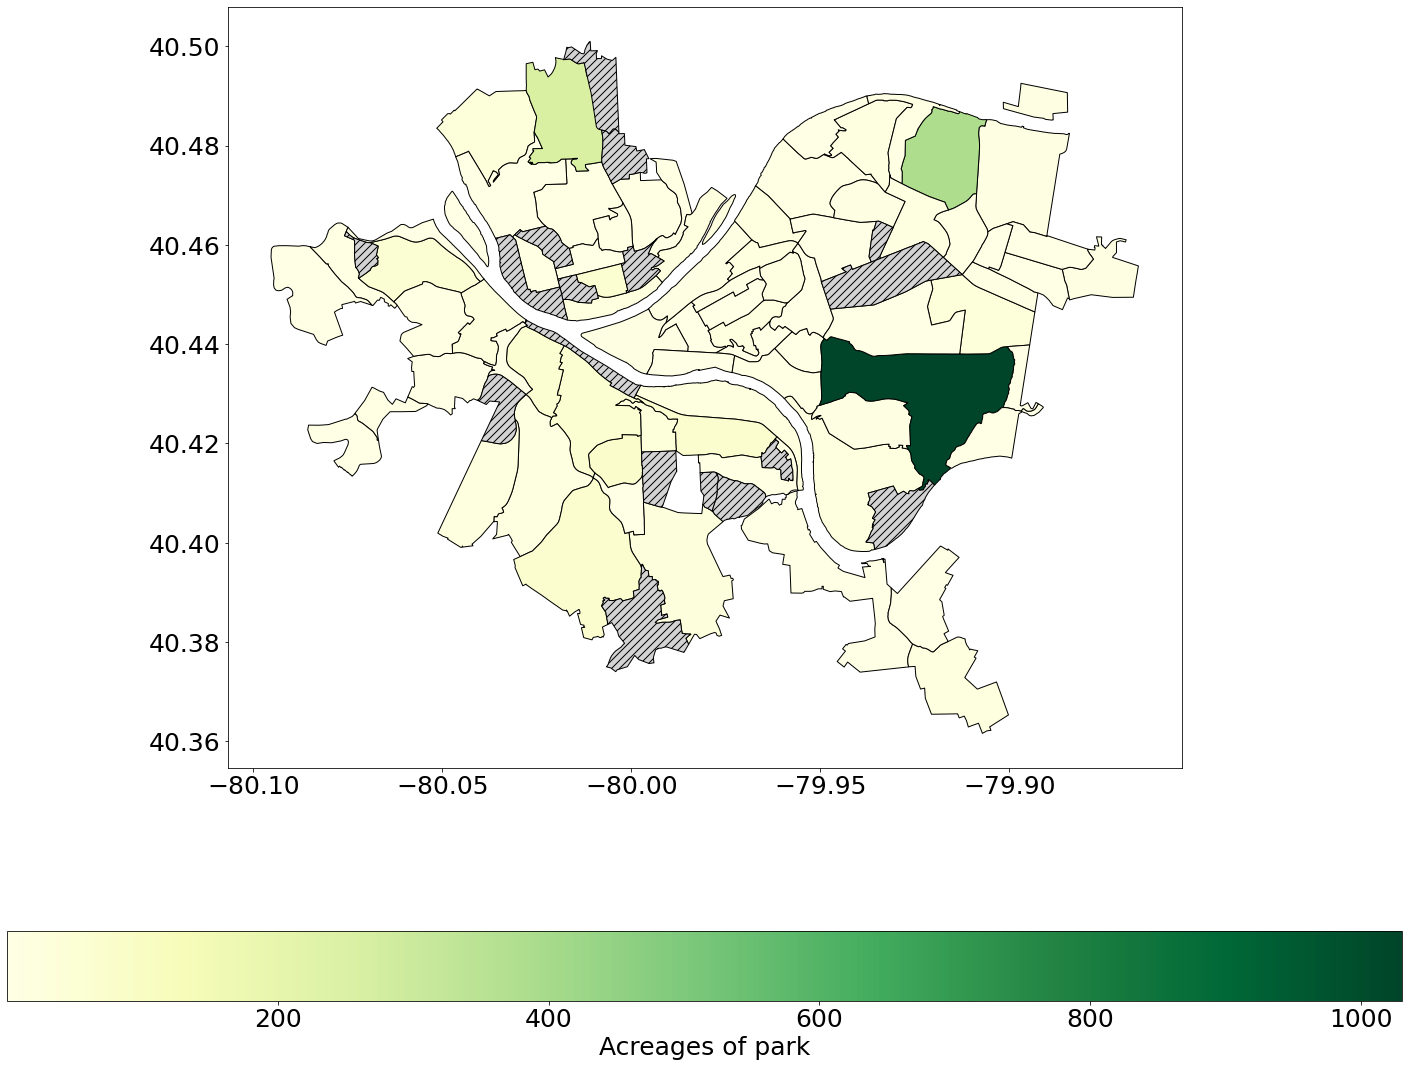

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib as plt
import sys
%matplotlib inline

# CSV Imports
city_parks = pd.read_csv('datasets/parks/city_parks.csv')
parks = pd.read_csv('datasets/parks/parks.csv')

# Set up font sizes
plt.rc('font', size=25)

# Shapefile imports (used by geopandas to make maps)
parks_shape = gpd.read_file('datasets/parks/Parks.shp')
neighborhoods = gpd.read_file('datasets/neighborhood/Neighborhoods_.shp')

# Merge the dataframes on the park names (which is shared across datasets), 
# we'll use this to eventually group by neighborhood
# and then gather location and area data.
merged_parks = pd.merge(city_parks, parks, on='name')
# Then get the acreage out of those and sort descending, so the neighborhood
# with the highest acreage of park comes out on top.
acreages = merged_parks.groupby('neighborhood')['acreage'].sum().sort_values(ascending=False)

# Finally make a map merging neighborhood information with the acreage information we got from the dataframes.
acres_map_df = neighborhoods.merge(acreages.rename('acreage'), how='left', left_on='hood', right_on='neighborhood')
acres_map = acres_map_df.plot(
               column='acreage',
               cmap='YlGn',
               edgecolor='black', 
               legend=True, 
               legend_kwds={'label':'Acreages of park', 'orientation':'horizontal'}, 
               figsize=(25,20),
               missing_kwds={'color':"lightgrey", "hatch":"///"}
              )

Right off the bat, you can see that there are a few neighborhoods dominating the ring when it comes to access to parks (looking at you, Squirrel Hill South... 👀). Note that neighborhoods that are hatch gray did not have any data.

Out of curiosity, I decided to also overlay the actual locations of the parks themselves onto this heatmap, to better visualise where all that park was that was so clearly defining a winner.

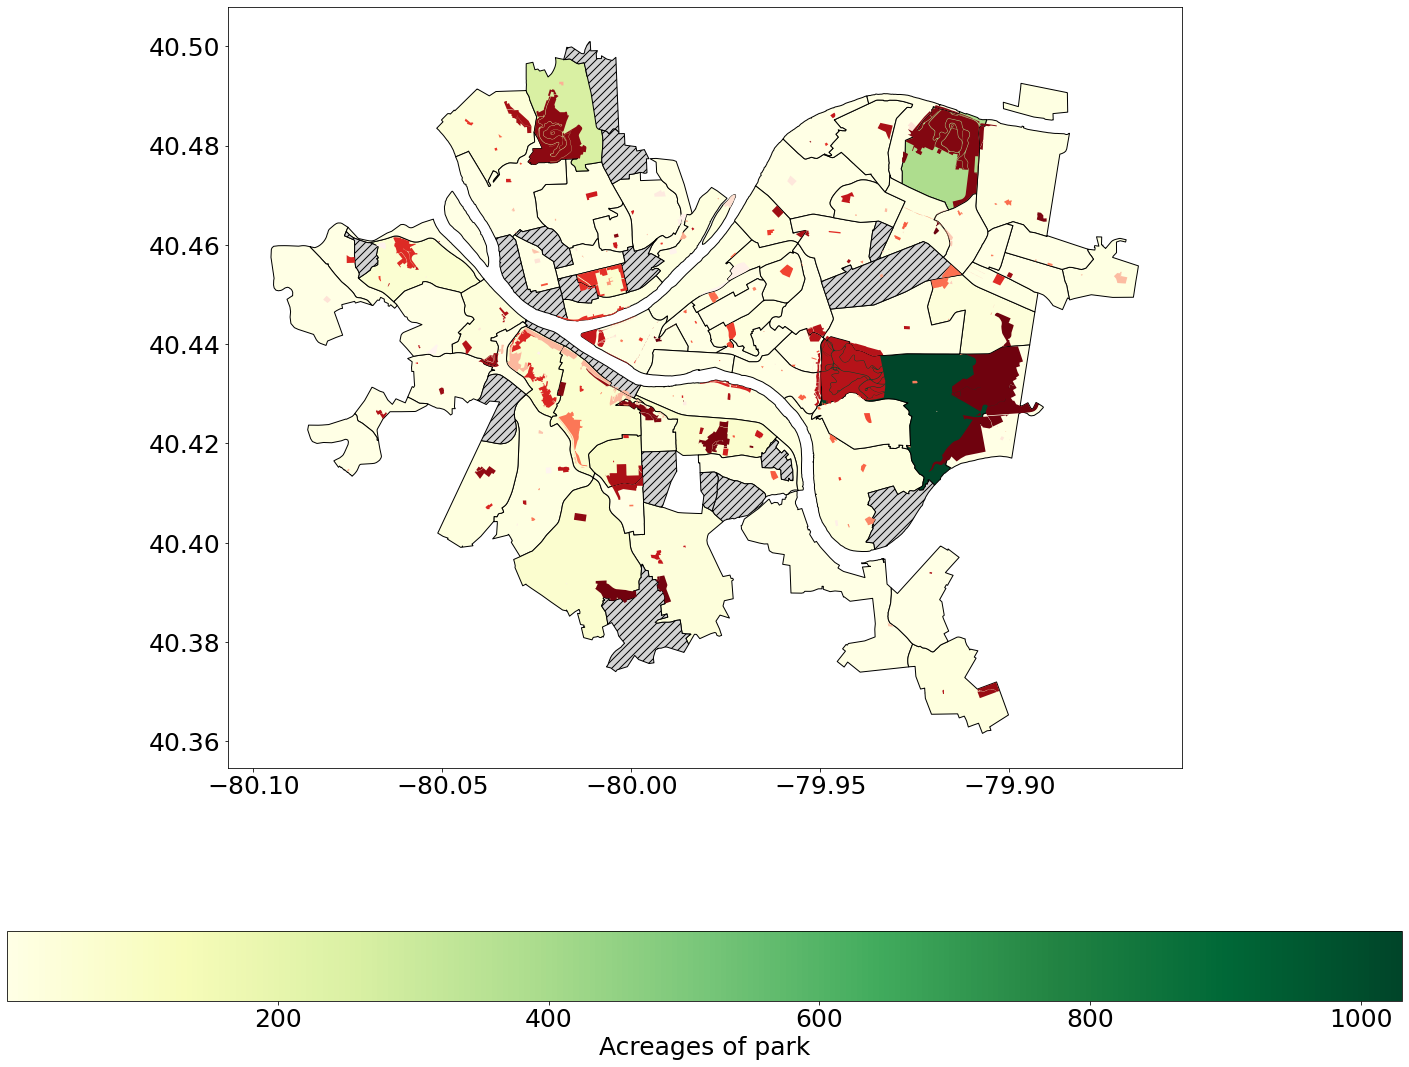

In [3]:
# For some reason in IPython I need to replot the above map before I can plot an overlay onto it.
# This probably has to do with the %matplotlib inline feature.
acres_map = acres_map_df.plot(
               column='acreage',
               cmap='YlGn',
               edgecolor='black', 
               legend=True, 
               legend_kwds={'label':'Acreages of park', 'orientation':'horizontal'}, 
               figsize=(25,20),
               missing_kwds={'color':"lightgrey", "hatch":"///"}
              )
# And here is a map with the actual parks overlayed onto it:
parks_map = parks_shape.plot(ax=acres_map, figsize=(25,20), cmap='Reds')

Something interesting that this map shows, in my opinion, is that neighborhoods that are physically bordering large amounts of park, but who don't include it within their boundaries, are getting a bad rap. This is actually what initially inspired me to roll with the idea of translating each neighborhood into a graph node with an acreage value, with edges that are assigned the physical distance between neighborhoods, then running a graph algorithm to determine the neighborhoods with the most park the *closest*. However, I decided to scrap this idea because--after some consideration--I realized it wouldn't actually change the winner, it would just change the runners up (and it would be pretty difficult to implement; I would have to roll my own graph objects for each neighborhood). 

Now that there is some geographic context to the data, let's lay it out in a way that shows just how wide the margin is between the winning neighborhood and the rest of them:

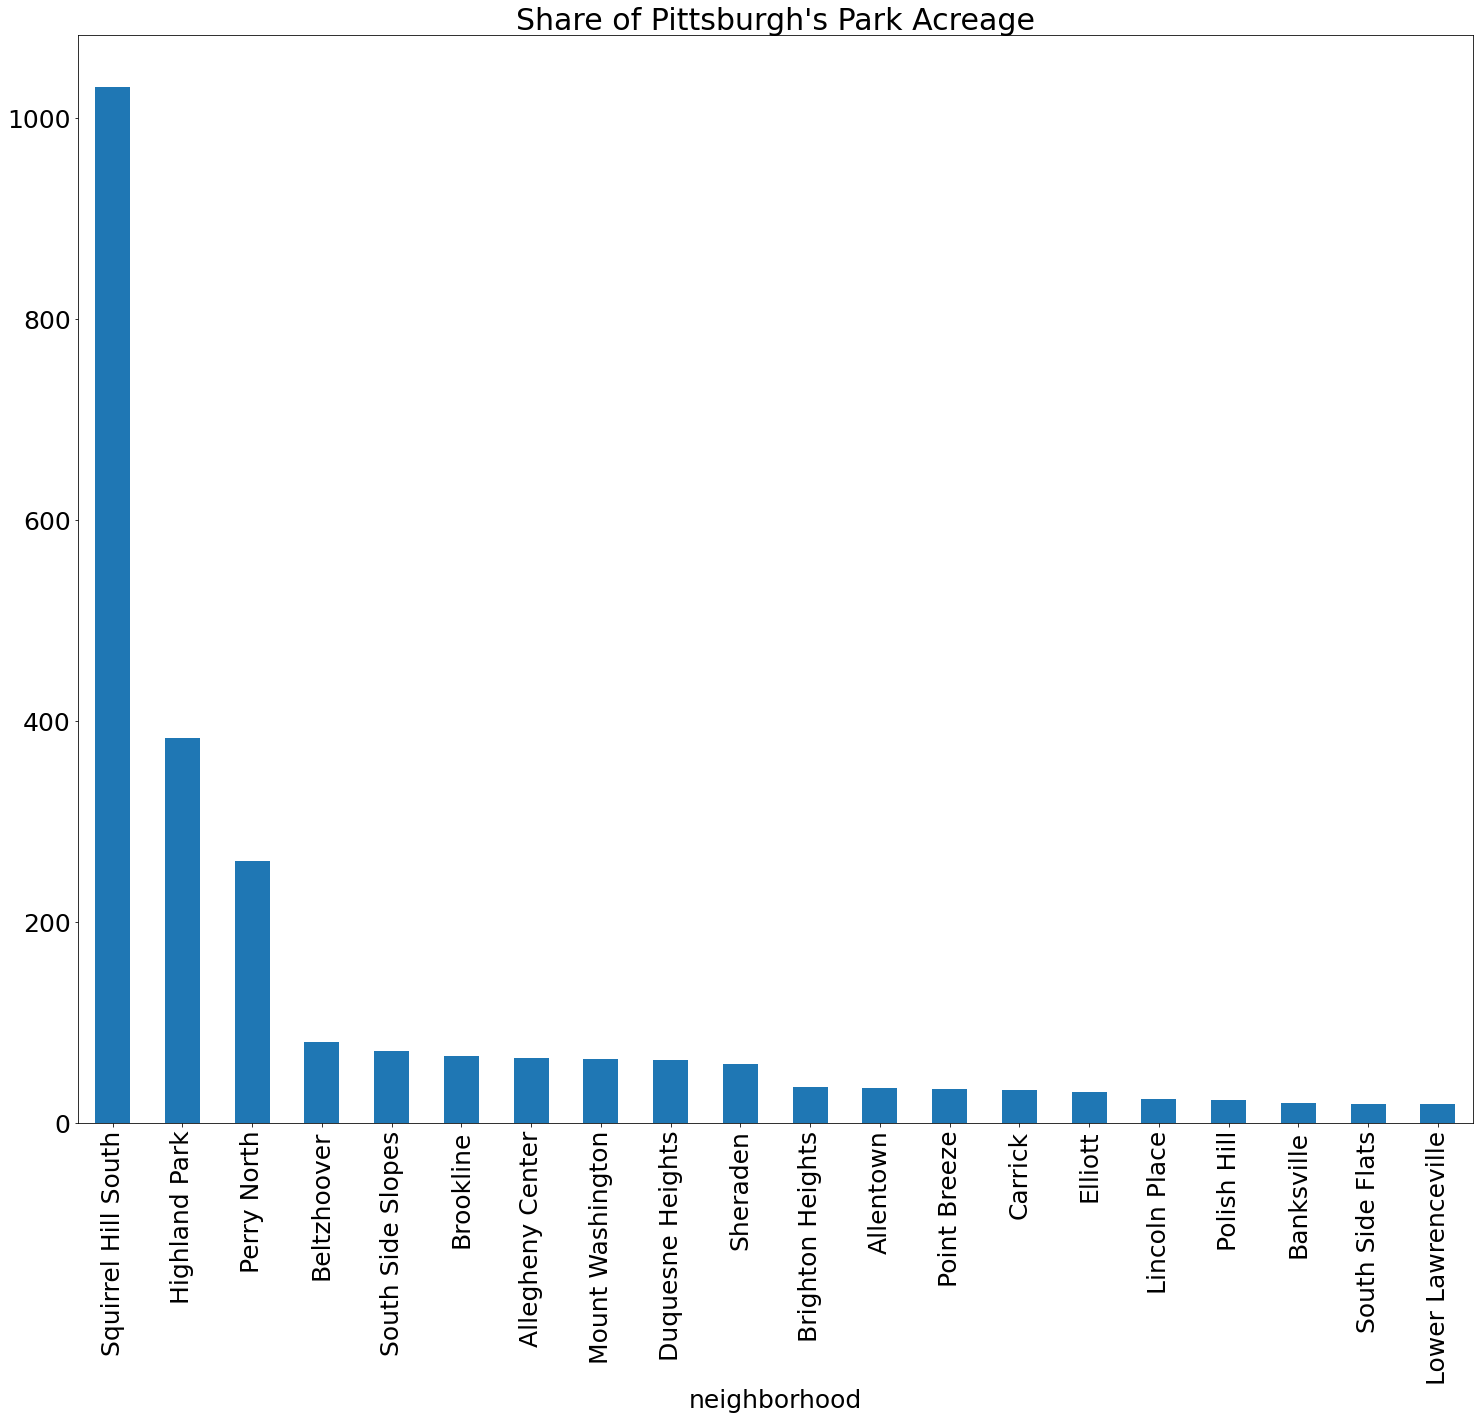

In [4]:
# Note that only the first 20 are shown for brevity, but the trend continues asymptotically down.
acreages.head(20).plot(kind='bar',
                       fontsize=25,
                       x='neighborhood',
                       y='acres',
                       figsize=(25,20),
                       title="Share of Pittsburgh's Park Acreage")

This chart might make it even clearer than the maps do just how much more park Squirrel Hill South has than literally every other neighborhood in Pittsburgh. The next two neighborhoods combined don't even add up to the same amount as Squirrel Hill South. A winner for this metric is, at this point, kind of a given... 

For this metric, **Squirrel Hill South** won, clearly. Here's the top five in table form, anyway:

In [5]:
acreages.head(5)

neighborhood
Squirrel Hill South    1030.808354
Highland Park           383.018646
Perry North             260.202754
Beltzhoover              80.150916
South Side Slopes        71.245957
Name: acreage, dtype: float64

# The (Combined) Metric

To decide the best neighborhood in Pittsburgh, we combined our three individual metrics into one by looking for a neighborhood that covered all of our individual metrics.

The best neighborhood had to be among the neighborhoods with the most acres of park, the most public art installations, and the best parking rates and number of available parking locations.

No neighborhood won all three metrics in first place, so we decided to reduce the data by dividing our outcomes by the max values of each, so that all of our numbers would be reduced to percentages of the highest value. That way, we could combine all of our data without having to worry about the differences in data sizes. Then we added these normalized values up and picked the neighborhood that had the highest sum of these values. 

First, all of the main, manipulated data, needed to apply the reduction formula:
```py
for each dataset:
    for each entry:
        entry /= maximum of dataset
```

Thankfully, with the way mathematical operators can be applied straight to Series and DataFrames in Pandas, this does not need any loops, actually.

In [6]:
reduced_acreage = acreages/acreages.max()
print(reduced_acreage.head(10))

neighborhood
Squirrel Hill South    1.000000
Highland Park          0.371571
Perry North            0.252426
Beltzhoover            0.077755
South Side Slopes      0.069117
Brookline              0.064280
Allegheny Center       0.062001
Mount Washington       0.061419
Duquesne Heights       0.060512
Sheraden               0.056878
Name: acreage, dtype: float64


neighborhood
Squirrel Hill South    1.000000
Highland Park          0.371571
Perry North            0.252426
Beltzhoover            0.077755
South Side Slopes      0.069117
Name: acreage, dtype: float64


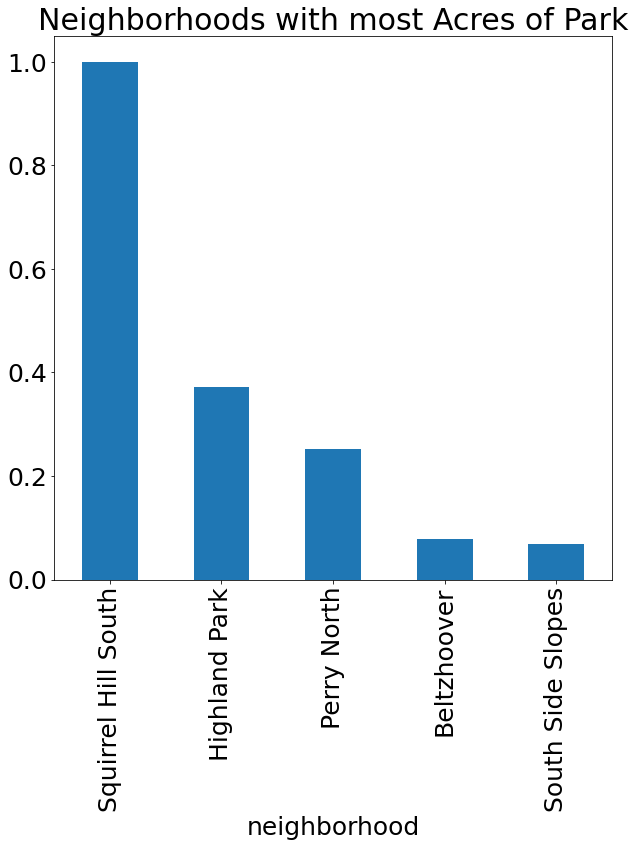

In [8]:
# There is no need to reimport anything here, as the kernel runs as if
# all code cells were in the same interpreter session.
print(reduced_acreage.head(5))
reduced_acreage.head(5).plot(kind='bar', title="Neighborhoods with most Acres of Park", figsize=(10,10))

neighborhood
Central Business District    1.000000
Squirrel Hill South          0.740741
Allegheny Center             0.666667
Highland Park                0.370370
South Side Flats             0.333333
dtype: float64


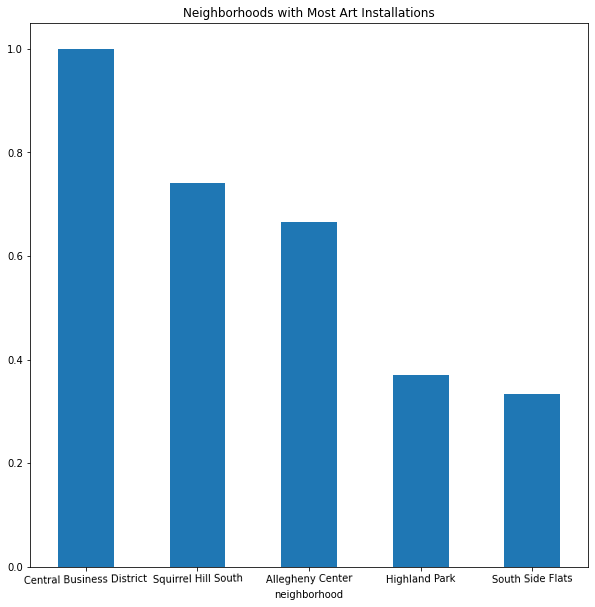

In [49]:
%store -r percent_art
print(percent_art.head(5))
percent_art.head(5).plot(kind='bar', title="Neighborhoods with Most Art Installations", rot=True, figsize=(10,10))

node
South Side       0.833333
Squirell Hill    0.816514
Uptown           0.775229
East Liberty     0.770642
Strip Distri*    0.729358
Name: combined, dtype: float64


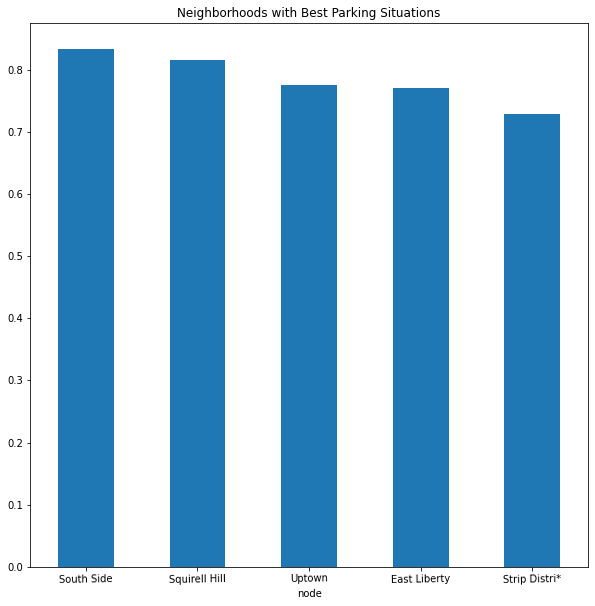

In [50]:
%store -r best_parking

# Combine the parking rates and parking locations data and average, row-wise
best_parking['combined'] = best_parking[['rates', 'count']].astype(float).mean(axis=1)

print(best_parking['combined'].sort_values(ascending=False).head(5))
best_parking['combined'].sort_values(ascending=False).head(5).plot(kind='bar', title="Neighborhoods with Best Parking Situations", rot=True, figsize=(10,10))

Squirrel Hill South          1.740741
Central Business District    1.008461
South Side                   0.833333
East Liberty                 0.819641
Squirell Hill                0.816514
dtype: float64


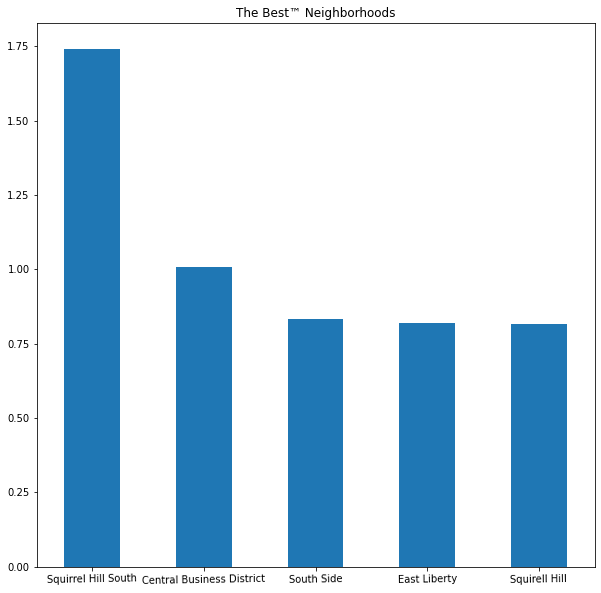

In [51]:
# THIS IS NOT HOW WE SHOULD LEAVE THIS, LET'S MAKE A **STACKED** GRAPH OF ALL OF THE VALUES
best_neighborhoods = (reduced_acreage.add(percent_art, fill_value=0).add(best_parking['combined'], fill_value=0)).sort_values(ascending=False).head(5)
print(best_neighborhoods)
best_neighborhoods.plot(kind='bar', title="The Best™ Neighborhoods", rot=True, figsize=(10,10))

Note that due to a naming convention difference across a couple of datasets, Squirrel Hill was separated into two separately named neighborhoods here. But, thankfully, it doesn't affect the outcome, because adding the values of the different variations of Squirrel Hill together still results in a clear winner. Speaking of which...

# The Best Neighborhood

So, after all of that, which is the best? 

Drumroll please ... 🥁

**Squirrel Hill South!**

# Conclusions
***THIS PART IS NOT FINISHED***

 *Gavin's response:* Personally, I agreed with the outcome of this analysis. I remember spending a lot of time in Squirrel Hill (namely the parks, of course!) as a kid. I think that having access to nature like that is good for people, especially young, developing people and families. There is ample research available to show that access to nature has several benefits to people's overall health. Despite how much access to nature means to me personally, this aspect of a neighborhood was weighted equally to the other aspects we inspected according to our percentage-based algorithm, and yet the neighborhood that won this category managed to take the final win as well. Personally I think it goes to show that neighborhoods which excel in one quality will tend to excel in others, as well. Taking a slight deviation into the philosophical, this reflects the intertwined, systemic nature of both wealth and poverty. A neighborhood that is wealthy enough to afford many acres of park might also be wealthy enough to invest in better education and housing, and might attract more businesses, thereby creating more jobs, *thereby reducing crime, violence, and increasing wealth in a feedback loop.* This concept is why I think that it is important to be system-critical in analyses like this, to look at several different aspects of a system and closely examine how they interact. In this way, I appreciate what this analysis did: it combined several seemingly unrelated data points and looked at a neighborhood more as a whole. Who would have thought that more parks correlated with better parking at all?

 *Collin's response:* I agree that Squirell Hill is the best neigborhood in Pittsburgh. If I stay in Pittsburgh after graduation that's likely where I'll move to. I think it's a really nice neighborhood and it also has Napoli Pizza!